In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/xai-data/clinical_mastitis_cows.csv


In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import shap

2024-06-24 06:31:05.865046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 06:31:05.865247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 06:31:06.033350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Processing

In [3]:
# Load the dataset
file_path = "/kaggle/input/xai-data/clinical_mastitis_cows.csv"  # Update with the correct path
df = pd.read_csv(file_path)

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Load dataset 

df = df.drop(columns=[ 'Day','Cow_ID','Milk_visibility'])
df = pd.get_dummies(df)

df

,Months after giving birth,Previous_Mastits_status,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Hardness,Pain,class1,Breed_Jersey,Breed_hostlene
0,1,0,150,180,150,180,150,181,150,181,43,0,0,0,True,False
1,1,0,152,180,152,185,151,180,152,181,42,0,0,0,True,False
2,1,0,152,182,153,186,151,186,153,183,41,0,0,0,True,False
3,1,0,155,183,155,189,155,182,155,186,40,0,0,0,True,False
4,1,0,150,186,150,181,150,185,150,188,41,0,0,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,5,0,243,285,310,361,241,285,246,281,43,1,0,1,True,False
6596,5,0,240,276,315,358,242,285,247,284,43,1,0,1,True,False
6597,5,0,242,286,315,365,237,279,248,288,43,1,0,1,True,False
6598,5,0,245,285,314,361,239,280,241,288,43,1,0,1,True,False


In [5]:
df['Breed_Jersey'] = df['Breed_Jersey'].apply(lambda x: 1 if x else 0)
df['Breed_hostlene'] = df['Breed_hostlene'].apply(lambda x: 1 if x else 0)


y = df['class1'].values


x = df.drop('class1', axis=1)
x.info()
x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6600 entries, 0 to 6599
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Months after giving birth  6600 non-null   int64
 1   Previous_Mastits_status    6600 non-null   int64
 2   IUFL                       6600 non-null   int64
 3   EUFL                       6600 non-null   int64
 4   IUFR                       6600 non-null   int64
 5   EUFR                       6600 non-null   int64
 6   IURL                       6600 non-null   int64
 7   EURL                       6600 non-null   int64
 8   IURR                       6600 non-null   int64
 9   EURR                       6600 non-null   int64
 10  Temperature                6600 non-null   int64
 11  Hardness                   6600 non-null   int64
 12  Pain                       6600 non-null   int64
 13  Breed_Jersey               6600 non-null   int64
 14  Breed_hostlene          

,Months after giving birth,Previous_Mastits_status,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Hardness,Pain,Breed_Jersey,Breed_hostlene
0,1,0,150,180,150,180,150,181,150,181,43,0,0,1,0
1,1,0,152,180,152,185,151,180,152,181,42,0,0,1,0
2,1,0,152,182,153,186,151,186,153,183,41,0,0,1,0
3,1,0,155,183,155,189,155,182,155,186,40,0,0,1,0
4,1,0,150,186,150,181,150,185,150,188,41,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,5,0,243,285,310,361,241,285,246,281,43,1,0,1,0
6596,5,0,240,276,315,358,242,285,247,284,43,1,0,1,0
6597,5,0,242,286,315,365,237,279,248,288,43,1,0,1,0
6598,5,0,245,285,314,361,239,280,241,288,43,1,0,1,0


col:  Months after giving birth


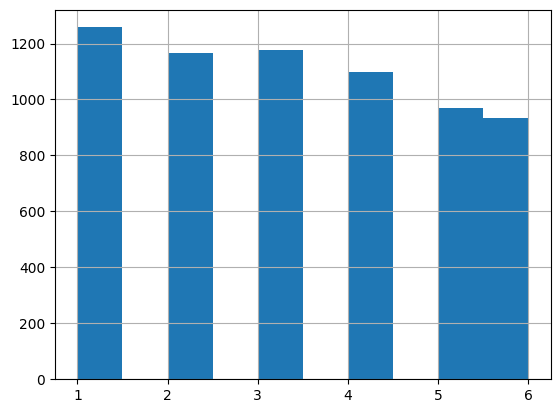

col:  Previous_Mastits_status


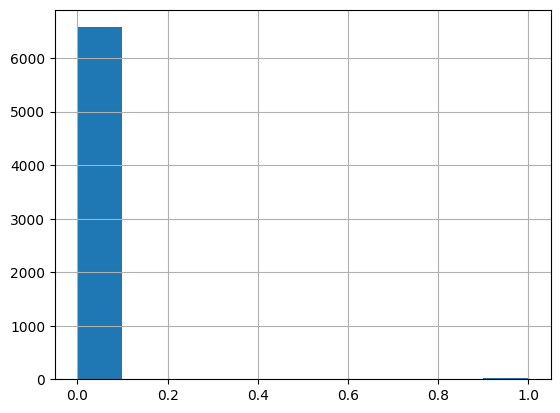

col:  IUFL


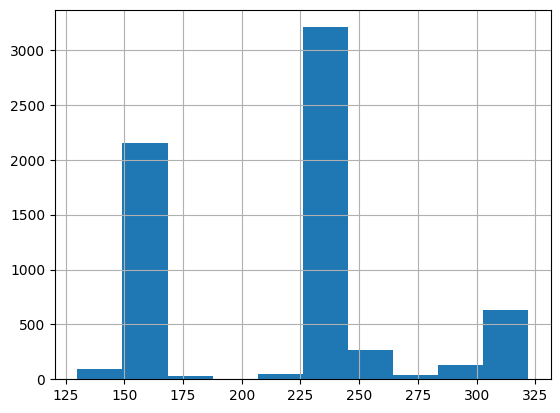

col:  EUFL


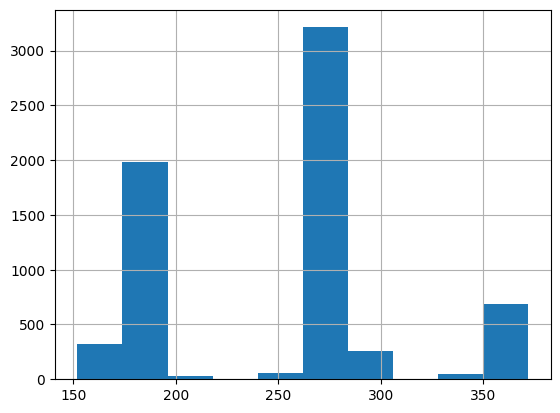

col:  IUFR


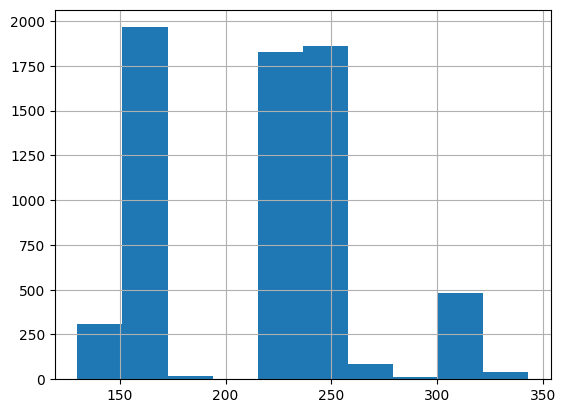

col:  EUFR


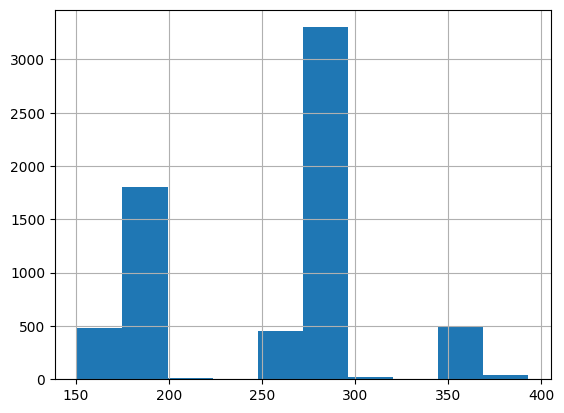

col:  IURL


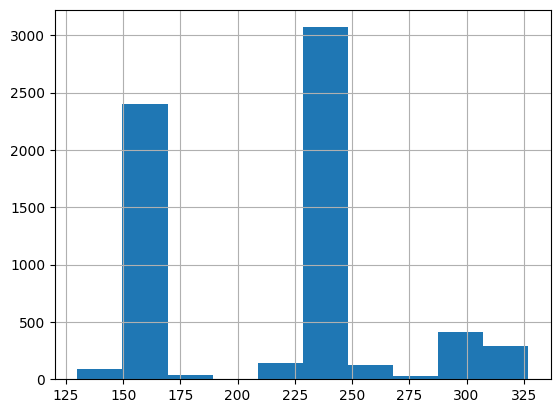

col:  EURL


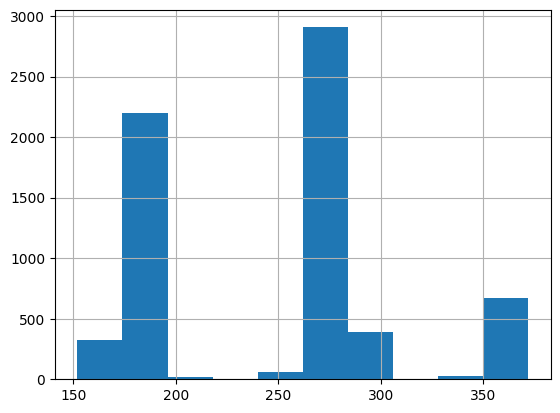

col:  IURR


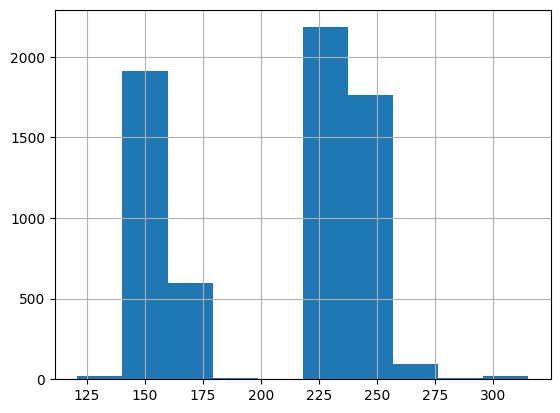

col:  EURR


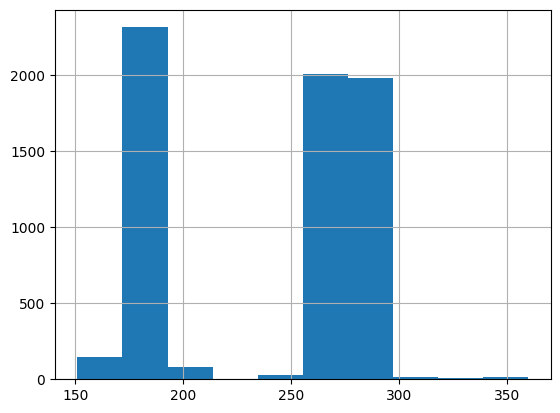

col:  Temperature


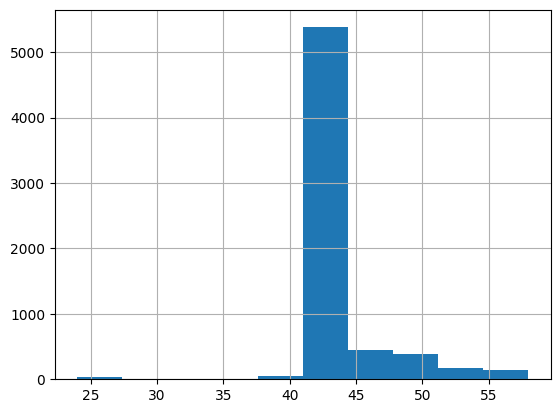

col:  Hardness


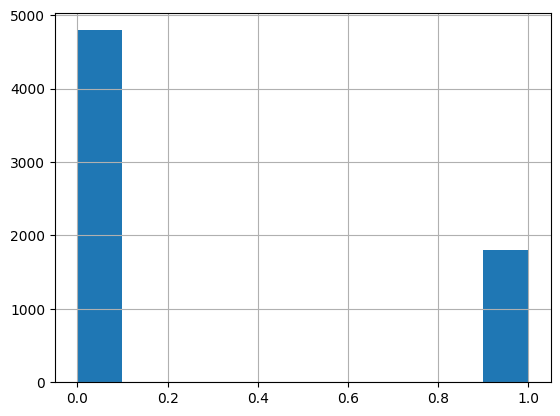

col:  Pain


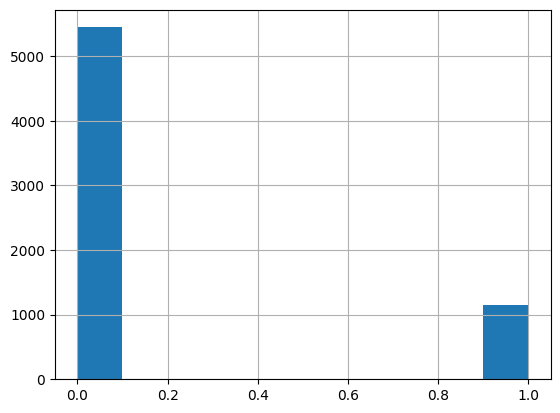

col:  class1


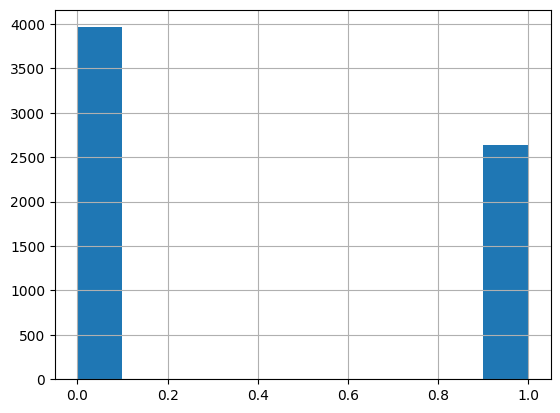

col:  Breed_Jersey


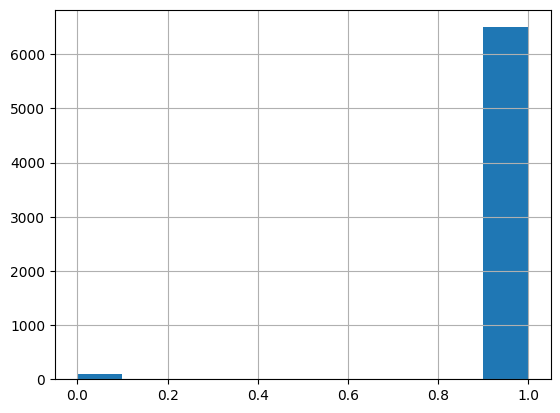

col:  Breed_hostlene


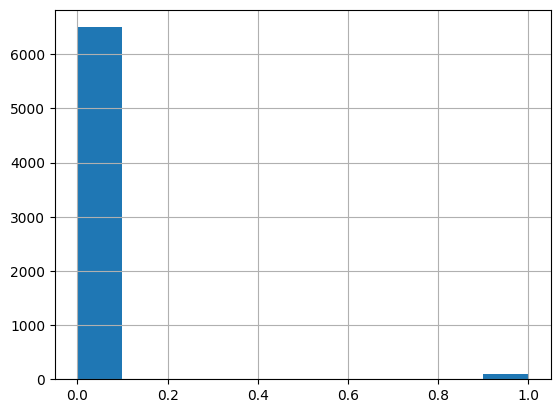

In [6]:
import matplotlib.pyplot as plt

columns = df.columns
for col in columns:
    print("col: ", col)
    df[col].hist()
    plt.show()

In [7]:
# Split data into training, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

print("Training set size:", X_train.shape[0], "or", round(X_train.shape[0]/x.shape[0]*100, 1), "%")
print("Test set size:", X_test.shape[0], "or", round(X_test.shape[0]/x.shape[0]*100, 1), "%")
print("Validation set size:", X_val.shape[0], "or", round(X_val.shape[0]/x.shape[0]*100, 1), "%")

Training set size: 4620 or 70.0 %
Test set size: 1326 or 20.1 %
Validation set size: 654 or 9.9 %


In [8]:
# Reshape the input data for LSTM (samples, time steps, features)
n_features = X_train.shape[1]
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, n_features))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, n_features))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], 1, n_features))

X_val_reshaped

array([[[  5,   0, 160, ...,   0,   1,   0]],

       [[  1,   0, 243, ...,   0,   1,   0]],

       [[  3,   0, 160, ...,   0,   1,   0]],

       ...,

       [[  3,   0, 164, ...,   0,   1,   0]],

       [[  3,   0, 232, ...,   0,   1,   0]],

       [[  4,   0, 231, ...,   0,   1,   0]]])

# LSTM Model

In [9]:
# Define and compile the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, n_features)),
    LSTM(50),
    Dense(1, activation='sigmoid')
])


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=50, validation_data=(X_val_reshaped, y_val))

Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7073 - loss: 0.5953 - val_accuracy: 0.8930 - val_loss: 0.3242
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8921 - loss: 0.3284 - val_accuracy: 0.8960 - val_loss: 0.2825
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8918 - loss: 0.3027 - val_accuracy: 0.9006 - val_loss: 0.2913
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8971 - loss: 0.2971 - val_accuracy: 0.8991 - val_loss: 0.3021
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8994 - loss: 0.3025 - val_accuracy: 0.8991 - val_loss: 0.2985
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8989 - loss: 0.3007 - val_accuracy: 0.8976 - val_loss: 0.3006
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9062 - loss: 0.2866 - val_accuracy: 0.8991 - val_loss: 0.3050
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8986 - loss: 0.3011 - val_accuracy: 0.

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,355 (392.02 KB)

 Trainable params: 33,451 (130.67 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 66,904 (261.35 KB)

In [13]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print("Test Accuracy:", test_acc)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9003 - loss: 0.2978
Test Accuracy: 0.9117646813392639


In [14]:
# Making predictions
predictions = model.predict(X_test_reshaped)
binary_predictions = (predictions > 0.5).astype(int)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [15]:
import pandas as pd

# Assuming 'predictions' are in the format returned by model.predict() and are probabilities
# Flatten the predictions array and round them off for better readability
predicted_probs = predictions.flatten().round(2)

# Create a DataFrame from the test set features
test_features = pd.DataFrame(X_test_reshaped.reshape(X_test_reshaped.shape[0], n_features), columns=X_test.columns)

# Add the predictions and the actual labels to the DataFrame
test_features['Predicted Probability'] = predicted_probs
test_features['Actual Label'] = y_test  

# Sort the DataFrame by 'Predicted Probability' to get the top predictions
test_features_sorted = test_features.sort_values(by='Predicted Probability', ascending=False)

In [16]:
# Display the top 5 predictions
top_5_predictions = test_features_sorted.head(5)
print(top_5_predictions)

      Months after giving birth  Previous_Mastits_status  IUFL  EUFL  IUFR  \
893                           3                        0   312   362   151   
640                           5                        0   312   360   157   
300                           1                        0   161   177   304   
298                           4                        0   158   182   301   
1009                          3                        0   242   289   242   

      EUFR  IURL  EURL  IURR  EURR  Temperature  Hardness  Pain  Breed_Jersey  \
893    181   151   182   152   181           52         1     1             1   
640    184   154   181   162   182           47         1     1             1   
300    361   158   173   160   173           45         1     1             1   
298    360   153   185   156   186           49         1     1             1   
1009   285   317   362   251   282           43         1     0             1   

      Breed_hostlene  Predicted Probability 

In [17]:
 top_5_predictions.to_csv("top_5_predictions_v1.0.csv", index=False)
top_5_predictions.info

<bound method DataFrame.info of       Months after giving birth  Previous_Mastits_status  IUFL  EUFL  IUFR  \
893                           3                        0   312   362   151   
640                           5                        0   312   360   157   
300                           1                        0   161   177   304   
298                           4                        0   158   182   301   
1009                          3                        0   242   289   242   

      EUFR  IURL  EURL  IURR  EURR  Temperature  Hardness  Pain  Breed_Jersey  \
893    181   151   182   152   181           52         1     1             1   
640    184   154   181   162   182           47         1     1             1   
300    361   158   173   160   173           45         1     1             1   
298    360   153   185   156   186           49         1     1             1   
1009   285   317   362   251   282           43         1     0             1   

      Breed_

In [18]:
# Convert probabilities to binary predictions
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

In [19]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Model Evaluation

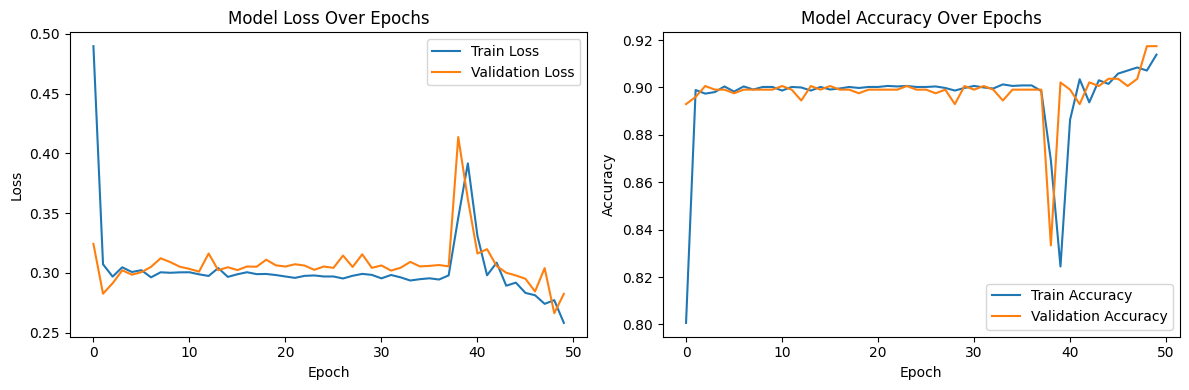

In [20]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

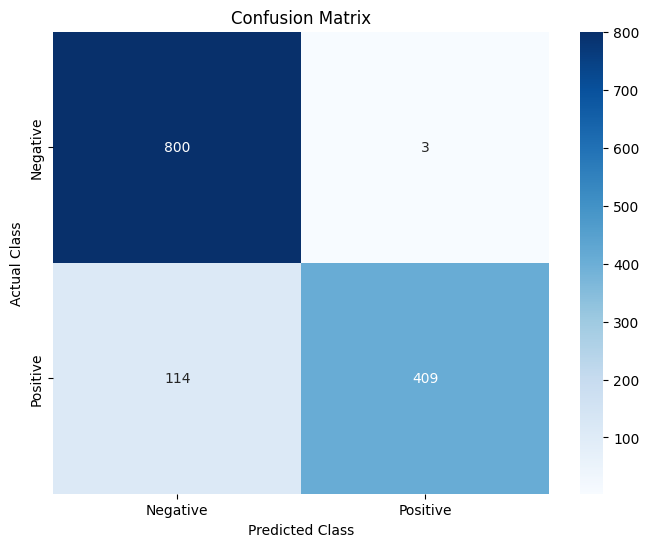

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the labels for the confusion matrix (adjust labels for your specific case)
labels = ['Negative', 'Positive']

# Create a heatmap from the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9117647058823529
Precision: 0.9927184466019418
Recall: 0.7820267686424475
F1 Score: 0.8748663101604278


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


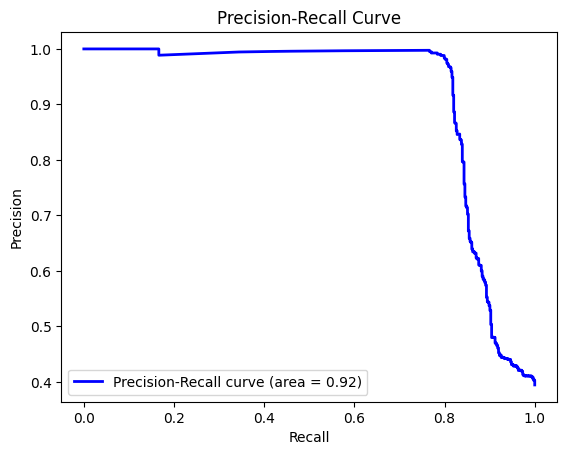

In [23]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Predict probabilities
y_pred_prob = model.predict(X_test_reshaped).ravel()
# Compute precision-recall pairs for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Compute average precision score
average_precision = average_precision_score(y_test, y_pred_prob)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (area = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

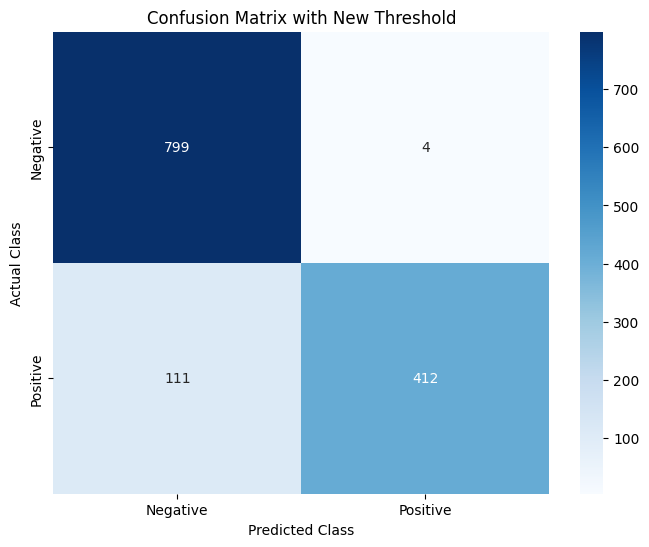

In [24]:
# Adjusting threshold to prioritize recall
new_threshold = 0.4
new_binary_predictions = (predictions > new_threshold).astype(int)
new_conf_matrix = confusion_matrix(y_test, new_binary_predictions)

# Redisplay new confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(new_conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix with New Threshold')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

True Negatives (TN): 800
False Positives (FP): 3
False Negatives (FN): 114
True Positives (TP): 409


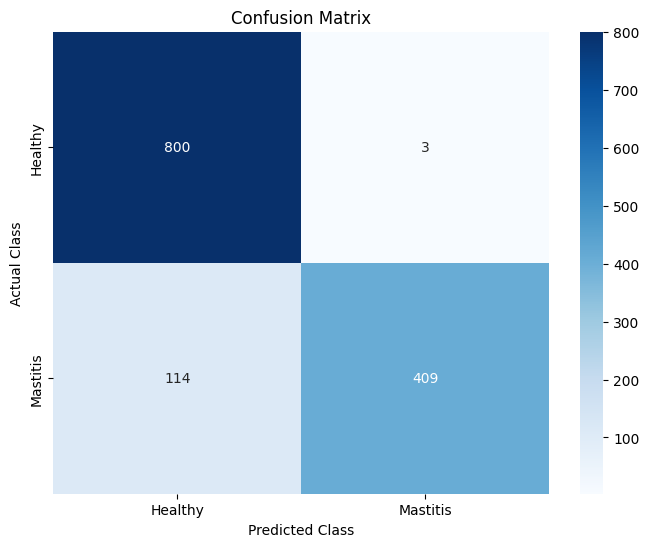

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming binary_predictions and y_test are already defined

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix.ravel()

# Print TN, FP, FN, TP
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

# Optional: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Healthy', 'Mastitis'], yticklabels=['Healthy', 'Mastitis'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


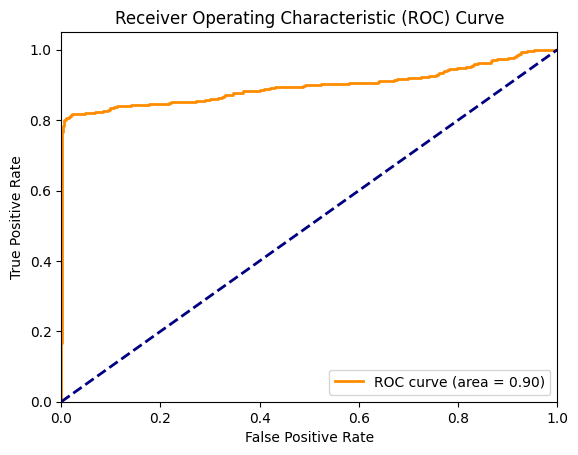

In [26]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_pred_prob = model.predict(X_test_reshaped).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [27]:
print(model.output_shape)

(None, 1)


In [28]:
# Making predictions
predictions = model.predict(X_test_reshaped)
binary_predictions = (predictions > 0.5).astype(int)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


# SHAP Value Calculation and Visualization

In [29]:
X_train_flat = X_train.values
X_test_flat = X_test.values

In [30]:
def model_predict(data):
    reshaped_data = data.reshape(data.shape[0], 1, data.shape[1])
    return model.predict(reshaped_data)

In [31]:
# Initialize KernelExplainer with a sample of the training data
explainer = shap.KernelExplainer(model_predict, shap.sample(X_train_flat, 100))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [32]:
shap_values = explainer.shap_values(X_test_flat[:20], nsamples=100)

  0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━

In [33]:
# Ensure that single_record_features is correctly shaped
single_record_features = X_test_flat[0]  # This assumes X_test_flat is (samples, features) and already 2D

# Check the shape or length
print("Features length:", len(single_record_features))

# Select SHAP values for a single record, assuming shap_values is a 2D array
single_record_shap_values = shap_values[0]
print("Correctly selected SHAP values length:", len(single_record_shap_values))

Features length: 15
Correctly selected SHAP values length: 20


In [34]:
explainer.expected_value

array([0.45803877])

In [35]:
single_record_features = X_test_flat[0] 
print("Features shape:", single_record_features.shape)

print("SHAP values:", single_record_shap_values)
print("Feature values:", single_record_features)


Features shape: (15,)
SHAP values: [[ 0.          0.         -0.05483665  0.          0.         -0.07404968
   0.          0.         -0.02405615 -0.06698416  0.03161867 -0.0625305
  -0.02214344  0.          0.        ]
 [ 0.00591788  0.02083756  0.02228323  0.          0.2827113   0.03238406
   0.01794053  0.06390303  0.03503842  0.          0.          0.0599618
   0.          0.          0.        ]
 [ 0.03648124 -0.02566664 -0.09714679  0.         -0.08923059  0.07898392
  -0.08371787 -0.1525617   0.          0.10361081  0.02692417 -0.04984032
   0.          0.          0.        ]
 [-0.01703892  0.          0.04549602  0.03658021 -0.02027969 -0.03198684
   0.07961099  0.32352192  0.05037197 -0.01632276  0.          0.09102503
   0.          0.          0.        ]
 [ 0.          0.         -0.05702559 -0.07510275 -0.1908635   0.10178889
  -0.02839009 -0.19932768  0.04827802  0.13338659  0.          0.
   0.          0.          0.        ]
 [-0.00625266  0.         -0.05718319  0

In [36]:
shap.initjs()

# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value[0], shap_values[0][1],        # Use the flattened SHAP values
    single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [37]:
shap_html = shap.force_plot(
    explainer.expected_value[0], shap_values[0][1],        # Use the flattened SHAP values
    single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

shap.save_html('/kaggle/working/force_plot_1.html', shap_html)

In [38]:
shap.initjs()

# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value[0], shap_values[0][0],        # Use the flattened SHAP values
    single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [39]:
shap_html = shap.force_plot(
    explainer.expected_value[0], shap_values[0][0],        # Use the flattened SHAP values
    single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

shap.save_html('/kaggle/working/force_plot_2.html', shap_html)

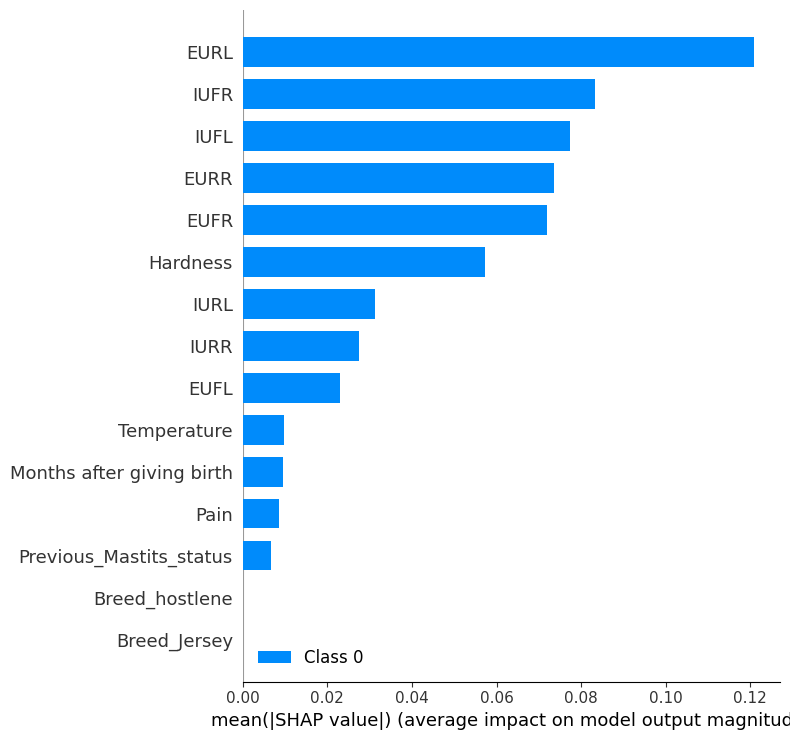

In [40]:
shap.summary_plot(
    shap_values,
    X_test_flat[:100],  # Use the features corresponding to the SHAP values
    feature_names=X_test.columns.tolist()[:15]  # Ensure the feature names list is correctly aligned
)

In [41]:
top_5_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 893 to 1009
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Months after giving birth  5 non-null      int64  
 1   Previous_Mastits_status    5 non-null      int64  
 2   IUFL                       5 non-null      int64  
 3   EUFL                       5 non-null      int64  
 4   IUFR                       5 non-null      int64  
 5   EUFR                       5 non-null      int64  
 6   IURL                       5 non-null      int64  
 7   EURL                       5 non-null      int64  
 8   IURR                       5 non-null      int64  
 9   EURR                       5 non-null      int64  
 10  Temperature                5 non-null      int64  
 11  Hardness                   5 non-null      int64  
 12  Pain                       5 non-null      int64  
 13  Breed_Jersey               5 non-null      int64  
 14

In [42]:
X_sample_test = top_5_predictions.drop(columns=[ 'Predicted Probability','Actual Label'])
X_sample_test

,Months after giving birth,Previous_Mastits_status,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Hardness,Pain,Breed_Jersey,Breed_hostlene
893,3,0,312,362,151,181,151,182,152,181,52,1,1,1,0
640,5,0,312,360,157,184,154,181,162,182,47,1,1,1,0
300,1,0,161,177,304,361,158,173,160,173,45,1,1,1,0
298,4,0,158,182,301,360,153,185,156,186,49,1,1,1,0
1009,3,0,242,289,242,285,317,362,251,282,43,1,0,1,0


In [43]:
Y_sample_test = top_5_predictions['Actual Label'].values
Y_sample_test

array([1, 1, 1, 1, 1])

In [44]:
X_test_flat[:20]
shap_values

[array([[ 0.        ,  0.        , -0.05483665,  0.        ,  0.        ,
         -0.07404968,  0.        ,  0.        , -0.02405615, -0.06698416,
          0.03161867, -0.0625305 , -0.02214344,  0.        ,  0.        ],
        [ 0.00591788,  0.02083756,  0.02228323,  0.        ,  0.2827113 ,
          0.03238406,  0.01794053,  0.06390303,  0.03503842,  0.        ,
          0.        ,  0.0599618 ,  0.        ,  0.        ,  0.        ],
        [ 0.03648124, -0.02566664, -0.09714679,  0.        , -0.08923059,
          0.07898392, -0.08371787, -0.1525617 ,  0.        ,  0.10361081,
          0.02692417, -0.04984032,  0.        ,  0.        ,  0.        ],
        [-0.01703892,  0.        ,  0.04549602,  0.03658021, -0.02027969,
         -0.03198684,  0.07961099,  0.32352192,  0.05037197, -0.01632276,
          0.        ,  0.09102503,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.05702559, -0.07510275, -0.1908635 ,
          0.10178889, -0.02839009,

In [45]:
X_sample_test_flat = X_sample_test.values
X_sample_test_flat

array([[  3,   0, 312, 362, 151, 181, 151, 182, 152, 181,  52,   1,   1,
          1,   0],
       [  5,   0, 312, 360, 157, 184, 154, 181, 162, 182,  47,   1,   1,
          1,   0],
       [  1,   0, 161, 177, 304, 361, 158, 173, 160, 173,  45,   1,   1,
          1,   0],
       [  4,   0, 158, 182, 301, 360, 153, 185, 156, 186,  49,   1,   1,
          1,   0],
       [  3,   0, 242, 289, 242, 285, 317, 362, 251, 282,  43,   1,   0,
          1,   0]])

In [46]:
shap_values_v1 = explainer.shap_values(X_sample_test_flat, nsamples=100)

  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [47]:
shap_values_v1

[array([[ 0.01443965, -0.02439692,  0.26422608,  0.04960858,  0.03760694,
          0.08268315,  0.02592668,  0.        ,  0.03406766,  0.01915966,
         -0.03628263,  0.07490624,  0.        ,  0.        ,  0.        ],
        [ 0.00869496,  0.03466067,  0.26684976,  0.04131494,  0.01966748,
          0.07677135, -0.0167326 ,  0.        ,  0.        ,  0.05435848,
         -0.03003777,  0.07496232,  0.01143548,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.08053359,  0.        ,  0.18740966,
          0.11863765,  0.        , -0.09073157,  0.10264747,  0.08297525,
          0.02083697,  0.0388029 ,  0.        ,  0.        ,  0.        ],
        [ 0.03411106, -0.02098891,  0.05805447,  0.        ,  0.20091017,
          0.09405624,  0.        , -0.07864671,  0.10240343,  0.08549323,
          0.        ,  0.06571803,  0.        ,  0.        ,  0.        ],
        [ 0.01734611, -0.05506631,  0.        ,  0.01039771,  0.03012372,
         -0.04213727,  0.11171462,

In [48]:
shap.initjs()
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][0],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [49]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][0],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_0.html', shap_html)

In [50]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][1],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [51]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][1],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_1.html', shap_html)

In [52]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][2],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [53]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][2],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_2.html', shap_html)

In [54]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][3],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [55]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][3],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_3.html', shap_html)

In [56]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][4],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [57]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][4],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_4.html', shap_html)

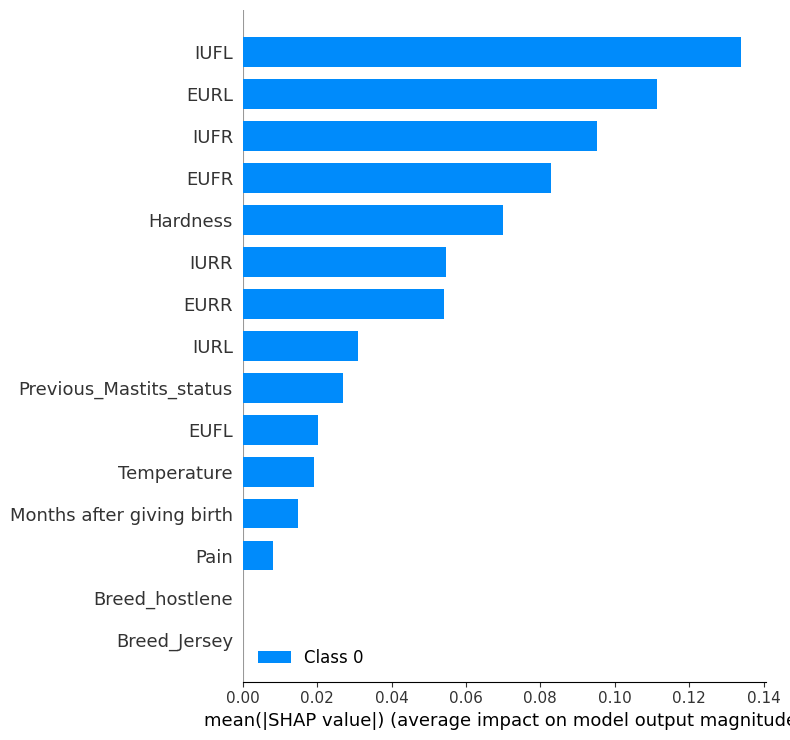

In [58]:
shap.summary_plot(
    shap_values_v1,
    X_sample_test_flat,
    feature_names=X_test.columns.tolist()[:15], 
)

In [59]:
shap.plots.force(explainer.expected_value,shap_values[0],feature_names=X_test.columns.tolist())

In [60]:
shap_html = shap.plots.force(explainer.expected_value,shap_values[0],feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/General_force_plot.html', shap_html)

In [61]:
shap.plots.force(explainer.expected_value,shap_values_v1[0],feature_names=X_test.columns.tolist())

In [62]:
  shap_html = shap.force_plot(
    explainer.expected_value,shap_values_v1[0],feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/top_5_predictions_force_plot_1.html', shap_html)

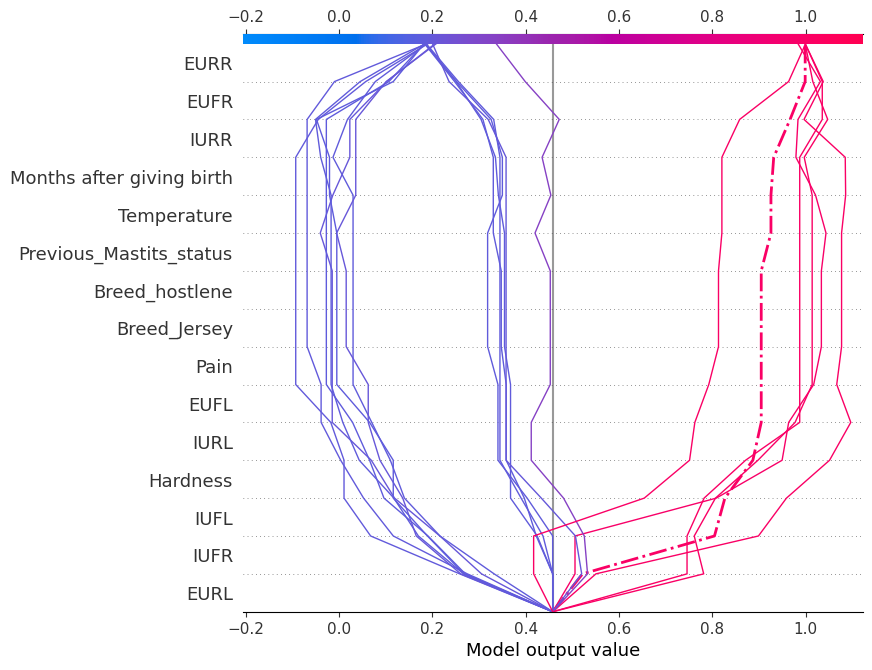

In [63]:
shap.decision_plot(explainer.expected_value, shap_values[0], feature_names=X_test.columns.tolist(),link="identity", highlight=1,legend_location="best",
                  feature_order="hclust")

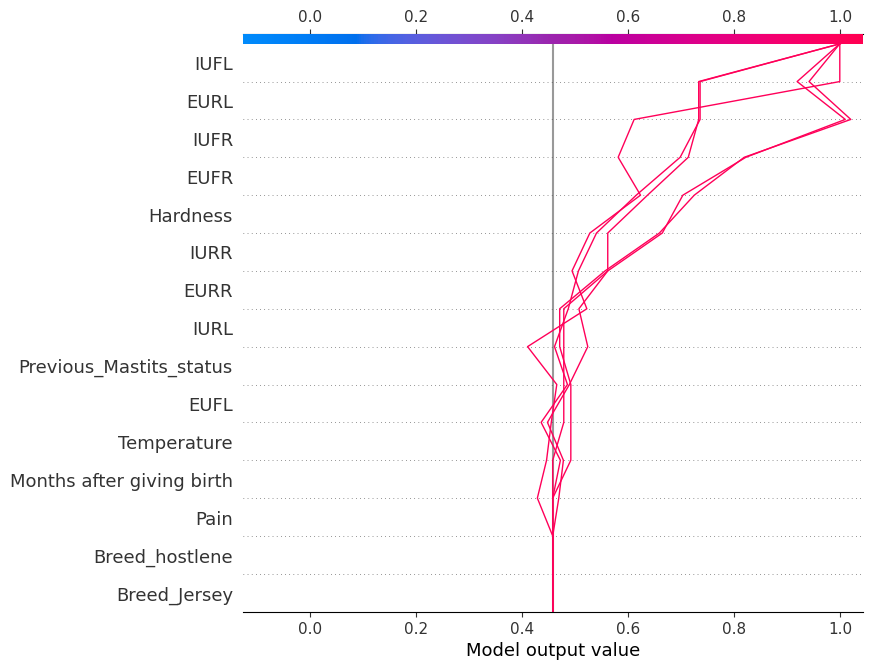

In [64]:
shap.decision_plot(explainer.expected_value, shap_values_v1[0], feature_names=X_test.columns.tolist(),)

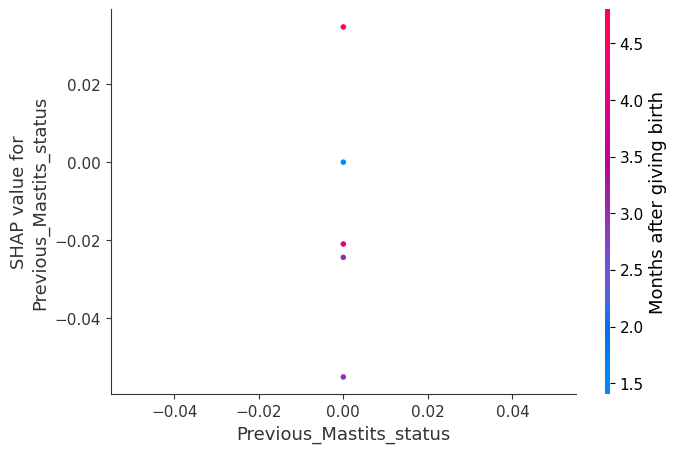

In [65]:
shap.dependence_plot(1, shap_values_v1[0], X_sample_test_flat,feature_names=X_test.columns.tolist())

In [66]:
# Flatten the SHAP values to match the expected shape (samples, features)
shap_values_flat = np.array(shap_values_v1).reshape((5, 15))
shap_values_flat


array([[ 0.01443965, -0.02439692,  0.26422608,  0.04960858,  0.03760694,
         0.08268315,  0.02592668,  0.        ,  0.03406766,  0.01915966,
        -0.03628263,  0.07490624,  0.        ,  0.        ,  0.        ],
       [ 0.00869496,  0.03466067,  0.26684976,  0.04131494,  0.01966748,
         0.07677135, -0.0167326 ,  0.        ,  0.        ,  0.05435848,
        -0.03003777,  0.07496232,  0.01143548,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.08053359,  0.        ,  0.18740966,
         0.11863765,  0.        , -0.09073157,  0.10264747,  0.08297525,
         0.02083697,  0.0388029 ,  0.        ,  0.        ,  0.        ],
       [ 0.03411106, -0.02098891,  0.05805447,  0.        ,  0.20091017,
         0.09405624,  0.        , -0.07864671,  0.10240343,  0.08549323,
         0.        ,  0.06571803,  0.        ,  0.        ,  0.        ],
       [ 0.01734611, -0.05506631,  0.        ,  0.01039771,  0.03012372,
        -0.04213727,  0.11171462,  0.3875449 , 

In [67]:
import shap
shap_values_expl = shap.Explanation(values=shap_values_flat, base_values=explainer.expected_value, data=X_test_flat, feature_names=X_test.columns.tolist())


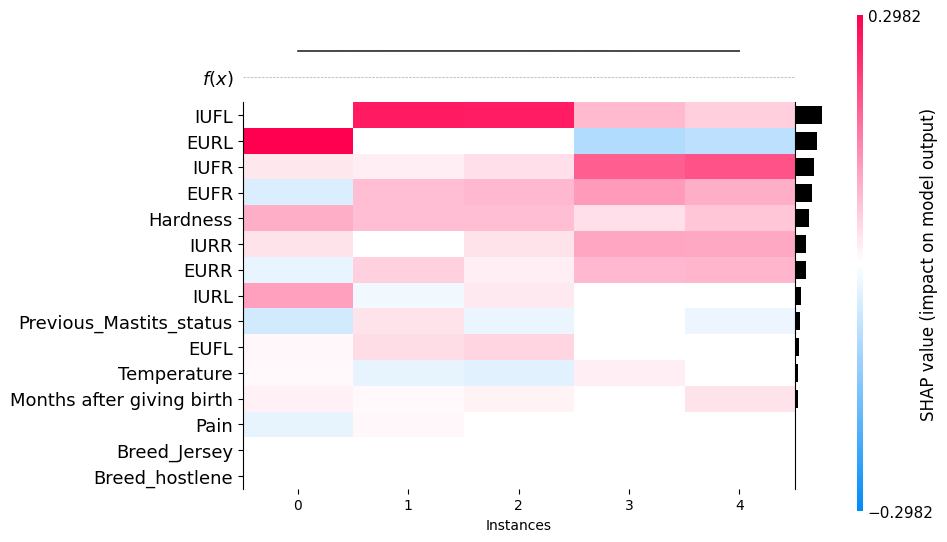

In [68]:
# Visualize SHAP values using heatmap
shap.plots.heatmap(shap_values_expl, max_display=15)

In [69]:
# Flatten the SHAP values to match the expected shape (samples, features)
shap_values_flat_1 = np.array(shap_values).reshape((20, 15))
shap_values_flat_1
shap_values_expl_1 = shap.Explanation(values=shap_values_flat_1, base_values=explainer.expected_value, data=X_test_flat[:20], feature_names=X_test.columns.tolist())


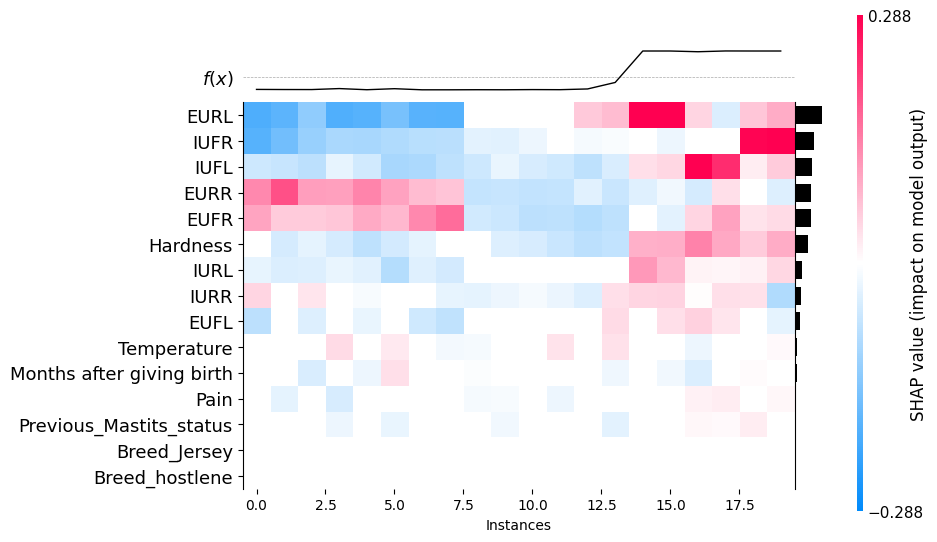

In [70]:
shap.plots.heatmap(shap_values_expl_1, max_display=15)

# Smooth Curve Model

Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9149 - loss: 0.2690 - val_accuracy: 0.9080 - val_loss: 0.2766
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9084 - loss: 0.2764 - val_accuracy: 0.9167 - val_loss: 0.2531
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9057 - loss: 0.2735 - val_accuracy: 0.9167 - val_loss: 0.2532
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9213 - loss: 0.2537 - val_accuracy: 0.9318 - val_loss: 0.2553
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9180 - loss: 0.2565 - val_accuracy: 0.9307 - val_loss: 0.2130
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9254 - loss: 0.2379 - val_accuracy: 0.9232 - val_loss: 0.2374
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9065 - loss: 0.2724 - val_accuracy: 0.9372 - val_loss: 0.2056
Epoch 8/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9228 - loss: 0.2383 - val_accuracy: 0.

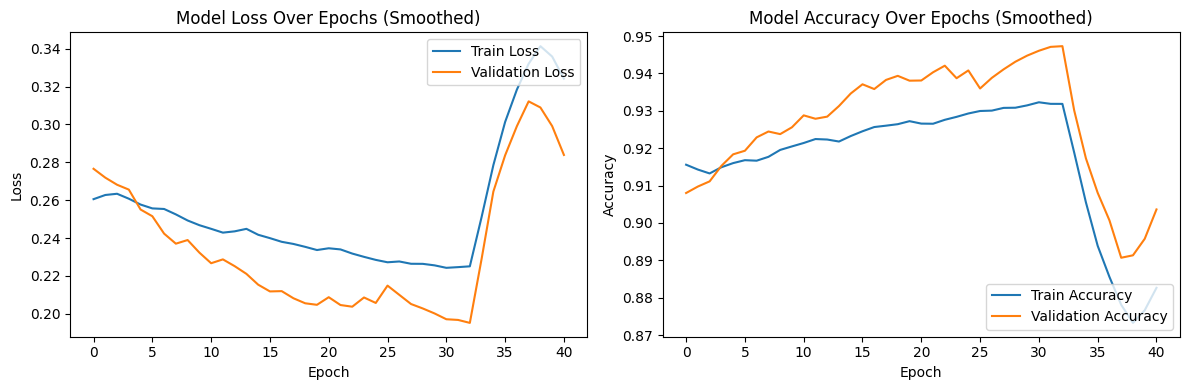

In [71]:
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# Smoothing function
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Smooth the curves
smooth_train_loss = smooth_curve(history.history['loss'])
smooth_val_loss = smooth_curve(history.history['val_loss'])
smooth_train_acc = smooth_curve(history.history['accuracy'])
smooth_val_acc = smooth_curve(history.history['val_accuracy'])

# Plot smoothed training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(smooth_train_loss, label='Train Loss')
plt.plot(smooth_val_loss, label='Validation Loss')
plt.title('Model Loss Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot smoothed training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(smooth_train_acc, label='Train Accuracy')
plt.plot(smooth_val_acc, label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9427 - loss: 0.2004 - val_accuracy: 0.9470 - val_loss: 0.1892 - learning_rate: 0.0010
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9422 - loss: 0.1980 - val_accuracy: 0.9426 - val_loss: 0.1947 - learning_rate: 0.0010
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9301 - loss: 0.2237 - val_accuracy: 0.9253 - val_loss: 0.2280 - learning_rate: 0.0010
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9313 - loss: 0.2185 - val_accuracy: 0.9513 - val_loss: 0.1851 - learning_rate: 0.0010
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9308 - loss: 0.2270 - val_accuracy: 0.9513 - val_loss: 0.1855 - learning_rate: 0.0010
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9324 - loss: 0.2203 - val_accuracy: 0.9513 - val_loss: 0.1941 - learning_rate: 0.0010
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9221 - loss: 0.2475 - 

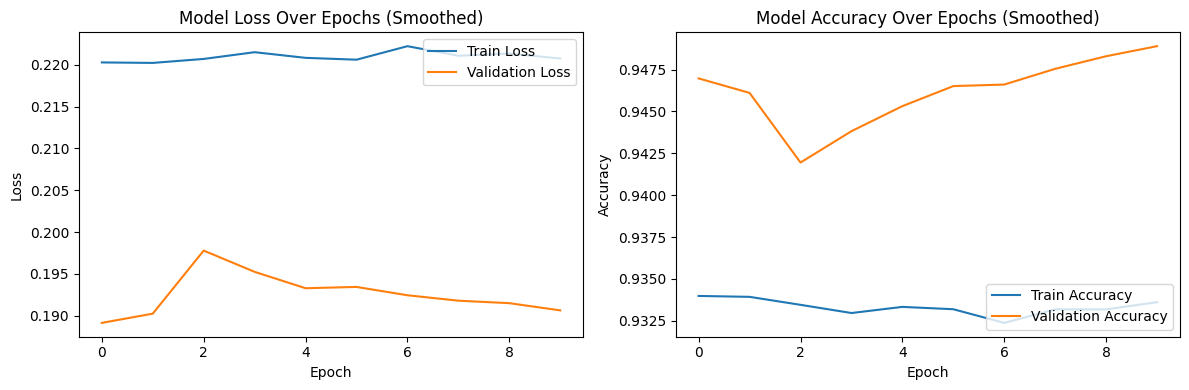

In [72]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define a learning rate schedule function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return  float(lr * tf.math.exp(-0.1).numpy())

# Implement learning rate scheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with early stopping and learning rate scheduler
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

# Smooth the curves
smooth_train_loss = smooth_curve(history.history['loss'])
smooth_val_loss = smooth_curve(history.history['val_loss'])
smooth_train_acc = smooth_curve(history.history['accuracy'])
smooth_val_acc = smooth_curve(history.history['val_accuracy'])

# Plot smoothed training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(smooth_train_loss, label='Train Loss')
plt.plot(smooth_val_loss, label='Validation Loss')
plt.title('Model Loss Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot smoothed training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(smooth_train_acc, label='Train Accuracy')
plt.plot(smooth_val_acc, label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


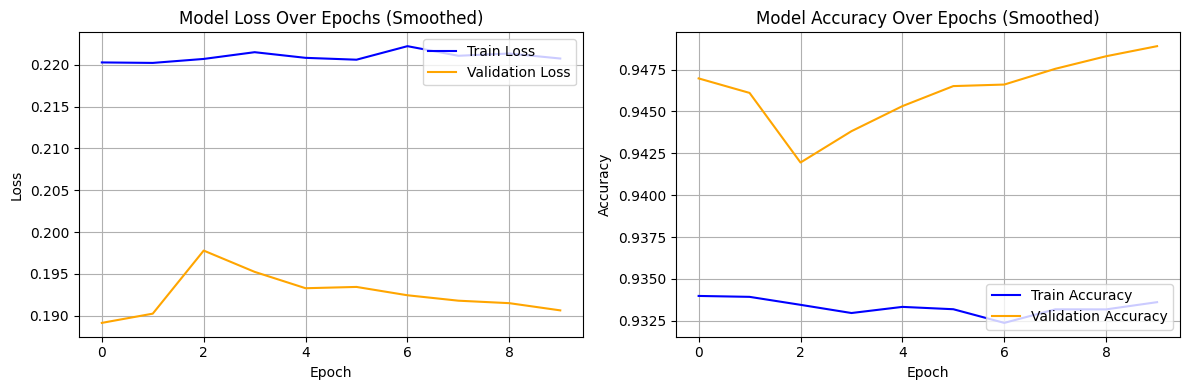

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Smoothing function
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Smooth the curves
smooth_train_loss = smooth_curve(history.history['loss'])
smooth_val_loss = smooth_curve(history.history['val_loss'])
smooth_train_acc = smooth_curve(history.history['accuracy'])
smooth_val_acc = smooth_curve(history.history['val_accuracy'])

# Enhanced Plot for Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(smooth_train_loss, label='Train Loss', color='blue')
plt.plot(smooth_val_loss, label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Enhanced Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(smooth_train_acc, label='Train Accuracy', color='blue')
plt.plot(smooth_val_acc, label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()




)




# Mean Shap Values

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# Assuming shap_values is the list of SHAP values you provided
shap_values = shap_values[0]  # Use the first element if shap_values is a list

# Calculate the mean absolute SHAP values
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

In [75]:
# Create a DataFrame for better visualization
feature_names = [
    'Months after giving birth', 'Previous Mastits status', 'IUFL', 'EUFL', 
    'IUFR', 'EUFR', 'IURL', 'EURL', 'IURR', 'EURR', 
    'Temperature', 'Hardness', 'Pain', 'Breed Jersey', 'Breed hostlene'
]

mean_abs_shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP Value|': mean_abs_shap_values
}).sort_values(by='Mean |SHAP Value|', ascending=False)

# Display the DataFrame
print(mean_abs_shap_df)


                      Feature  Mean |SHAP Value|
7                        EURL           0.120977
4                        IUFR           0.083291
2                        IUFL           0.077479
9                        EURR           0.073637
5                        EUFR           0.071909
11                   Hardness           0.057226
6                        IURL           0.031295
8                        IURR           0.027428
3                        EUFL           0.022885
10                Temperature           0.009669
0   Months after giving birth           0.009638
12                       Pain           0.008526
1     Previous Mastits status           0.006698
13               Breed Jersey           0.000000
14             Breed hostlene           0.000000


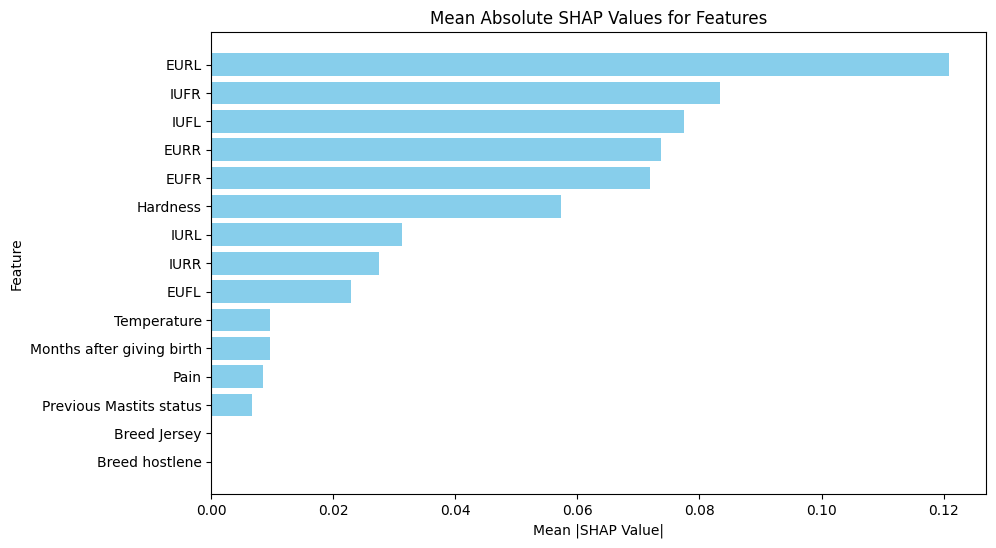

In [76]:
# Plot the mean absolute SHAP values
plt.figure(figsize=(10, 6))
plt.barh(mean_abs_shap_df['Feature'], mean_abs_shap_df['Mean |SHAP Value|'], color='skyblue')
plt.xlabel('Mean |SHAP Value|')
plt.ylabel('Feature')
plt.title('Mean Absolute SHAP Values for Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()
